# 🧠 Brain MRI Image Alzheimer Classifier 🧠
In this notebook we will classify T1-weighted MRI images from healthy and dementia patients

## First: Install Weights and Biases

In [1]:
!pip install wandb

Defaulting to user installation because normal site-packages is not writeable


## Next: Import all of your Python Packages
Be Sure your Kernel (in the top right of Jupyter Notebook) is set to: Tensorflow-2.7.0

In [2]:
import os, sys
sys.path.append(os.path.join(os.environ['HOME'],'.local','bin'))

import cv2, itertools, warnings, shutil, random
import wandb as wb
from wandb.keras import WandbMetricsLogger
import pandas as pd
import numpy as np
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img
warnings.filterwarnings('ignore')

from tensorflow import keras
from keras import layers
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

print("TensorFlow Version:", tf.__version__)
wb.login(); # USE YOUR API KEY TO LOGIN BELOW

TensorFlow Version: 2.7.0


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aalbizu (woodslab). Use `wandb login --relogin` to force relogin


## Here, we will define our settings for this experiment

In [3]:
class config:
    
    # specify the paths to datasets
    DOWNLOAD_DIR = Path(os.path.join(os.getcwd(),'input','Dataset'))
    ROOT_DIR = Path(os.path.join(os.getcwd(),'input'))
    TRAIN_DIR = ROOT_DIR.joinpath('train')
    TEST_DIR = ROOT_DIR.joinpath('test')
    VAL_DIR = ROOT_DIR.joinpath('val')

    # set the input height and width
    IMG_HEIGHT = 128
    IMG_WIDTH = 128
    
    NUM_EPOCHS = 20
    BATCH_SIZE = 64

# Initialize Weights and Biases
wb.init(project="wandb-tutorial",
           config={
               "batch_size": config.BATCH_SIZE,
               "n_epoch": config.NUM_EPOCHS,
               "image_size": [config.IMG_HEIGHT, config.IMG_WIDTH],
               "dataset": "kaggle",
           }
       )

## Next, we need to split our data into Training / Validation / Testing
The Model is training on the `training data` and performance is checked with the `validation data`

Once the model is trained, we can check the model performance with the `test data`

Found 6153 files belonging to 4 classes.


2023-09-26 13:34:02.177778: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 13:34:02.767193: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78911 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:87:00.0, compute capability: 8.0


Found 1223 files belonging to 4 classes.
Found 1206 files belonging to 4 classes.

Class names: ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']



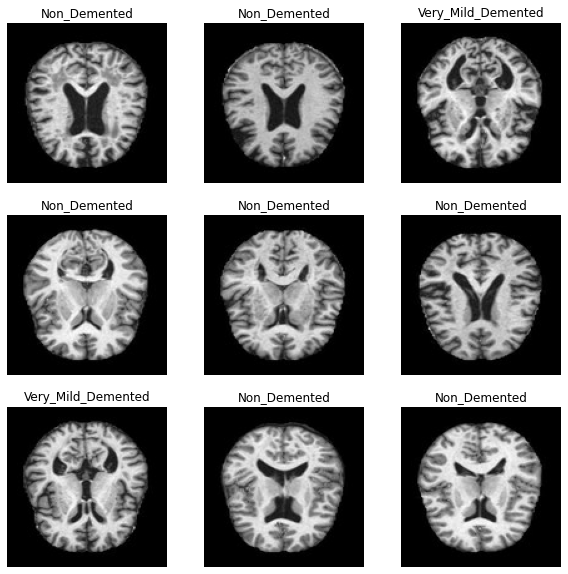

In [4]:
def split_and_copy_files(src_dir, dst_dirs):
    # List all files recursively
    all_files = [os.path.join(root, f) for root, dirs, files in os.walk(src_dir) for f in files]
    
    # Shuffle the list
    random.shuffle(all_files)
    
    # Split the files into three parts
    total_files = len(all_files)
    split1 = int(0.8 * total_files)
    split2 = int(0.9 * total_files)
    
    files_80 = all_files[:split1]
    files_10a = all_files[split1:split2]
    files_10b = all_files[split2:]
    
    # Copy files to the new locations
    for i, files in enumerate([files_80, files_10a, files_10b]):
        dst_dir = dst_dirs[i]
        os.makedirs(dst_dir, exist_ok=True)
        for file in files:
            classname = os.path.basename(os.path.dirname(file))
            if not os.path.exists(os.path.join(dst_dir, classname, os.path.basename(file))):
                os.makedirs(os.path.join(dst_dir, classname),exist_ok=True)
                shutil.copy(file, os.path.join(dst_dir, classname, os.path.basename(file)))

# Define the source directory and destination directories
dst_dirs = [config.TRAIN_DIR, config.VAL_DIR, config.TEST_DIR]

# Call the function
split_and_copy_files(config.DOWNLOAD_DIR, dst_dirs)

# Training Data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
dst_dirs[0],
seed=42,
image_size=(config.IMG_HEIGHT, config.IMG_WIDTH),
batch_size=64
)

# Validation Data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
dst_dirs[1],
seed=42,
image_size=(config.IMG_HEIGHT, config.IMG_WIDTH),
batch_size=64
)

# Testing Data
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
dst_dirs[2],
seed=42,
image_size=(config.IMG_HEIGHT, config.IMG_WIDTH),
batch_size=64
)

# Plot
class_names = train_ds.class_names
print(f'\nClass names: {class_names}\n')
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Now that we have our data sorted, lets check out the class imbalance
We will plot the frequency of each class

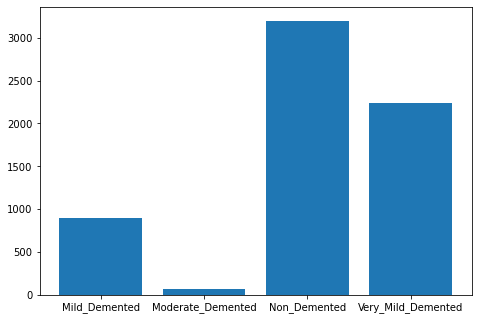

In [5]:
# Plot
fig = plt.figure();
ax = fig.add_axes([0,0,1,1]);
size = [896,64,3200,2240] # I just hardcoded this from kaggle (try to write some code to compute this directly)
ax.bar(class_names,size);
plt.show;

## With our data ready, we can construct our convolutional neural network 🤖

In [6]:
# Construct Model
model = keras.models.Sequential()
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(config.IMG_HEIGHT,config.IMG_WIDTH, 3)))
model.add(keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.20))
model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(64,"relu"))
model.add(keras.layers.Dense(4,"softmax"))

## "Every neural network would be lost with a loss function" - Socrates

In [7]:
# Define Loss
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "Adam",metrics=["accuracy"])

## Now, we can see what our model looks like 👀

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0

## What are we wating for, lets start training ! 💪
Batch size = 64 and Epochs = 20 

These settings are totally arbitrary but you can try messing with them to see if you get better performance (if you have time)

In [9]:
# Train
hist = model.fit(train_ds,validation_data=val_ds,epochs=config.NUM_EPOCHS, batch_size=config.BATCH_SIZE, callbacks=[WandbMetricsLogger()], verbose=1)

Epoch 1/20


2023-09-26 13:34:06.111372: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2023-09-26 13:34:07.756941: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


97/97 [==============================] - 5s 19ms/step - loss: 1.1484 - accuracy: 0.4911 - val_loss: 1.0065 - val_accuracy: 0.5822
Epoch 2/20
97/97 [==============================] - 2s 17ms/step - loss: 0.9221 - accuracy: 0.5620 - val_loss: 0.8422 - val_accuracy: 0.6705
Epoch 3/20
97/97 [==============================] - 2s 16ms/step - loss: 0.8122 - accuracy: 0.6412 - val_loss: 0.6441 - val_accuracy: 0.7441
Epoch 4/20
97/97 [==============================] - 2s 15ms/step - loss: 0.6908 - accuracy: 0.7008 - val_loss: 0.5472 - val_accuracy: 0.8283
Epoch 5/20
97/97 [==============================] - 2s 19ms/step - loss: 0.5839 - accuracy: 0.7489 - val_loss: 0.3760 - val_accuracy: 0.8929
Epoch 6/20
97/97 [==============================] - 2s 18ms/step - loss: 0.4538 - accuracy: 0.8115 - val_loss: 0.3037 - val_accuracy: 0.8986
Epoch 7/20
97/97 [==============================] - 2s 16ms/step - loss: 0.3531 - accuracy: 0.8619 - val_loss: 0.2042 - val_accuracy: 0.9411
Epoch 8/20
97/97 [======

## What even happen during training ? 😴
Lets make some plots to find out !

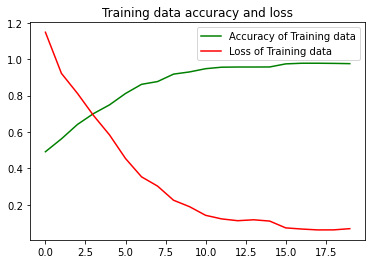

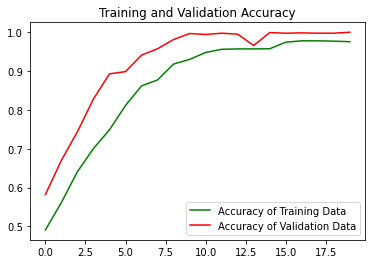

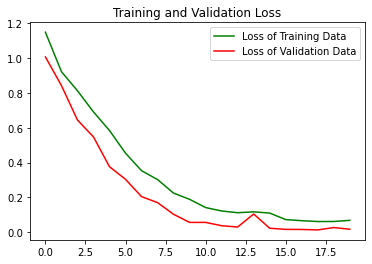

<Figure size 432x288 with 0 Axes>

In [10]:
get_ac = hist.history['accuracy']
get_los = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label='Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label='Loss of Training data')
plt.title('Training data accuracy and loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_los, 'g', label='Loss of Training Data')
plt.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

## But what about the test data ? 🤔🤔
Does this model even work on untrained data

19/19 [==============================] - 1s 14ms/step - loss: 0.0175 - accuracy: 0.9983


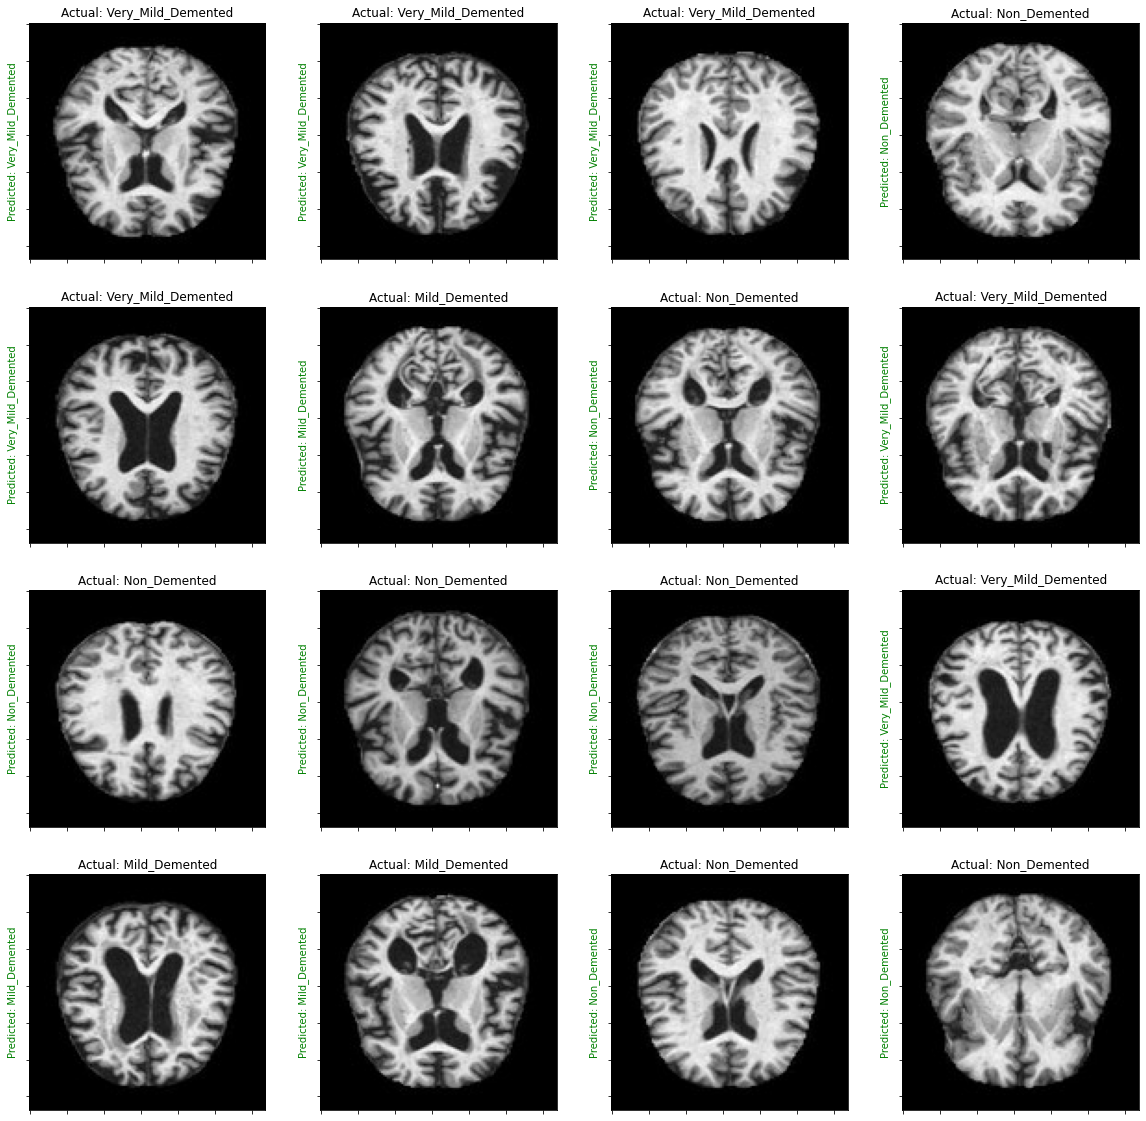

In [11]:
loss, accuracy = model.evaluate(test_ds,callbacks=[WandbMetricsLogger()])

plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'green'})
            
        else:
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'red'})
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])

# ✨ TA-DA ! ✨ You have create a robot neurologist 🎉
(Not Really...)

Since these are 2D images, this thing is completely worthless but it was fun anyway

Its about the journey, not the destination 🌈

byeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee